Importing the Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2

from scipy.misc import imread
from imgaug import augmenters as iaa
from tqdm import tqdm

import tensorflow as tf
sns.set()

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore")

['sample_submission.csv', 'train.csv', 'test', 'train']


Playing with Data

The Data is given in the form of 'train' and 'test' folders, each containing multiple 512x512 PNG images. Each of these images in the 'train' folder is named using an ID. The ID of the image is linked to target classes in the train.csv file.
Eg : The first image below  has protiens 16 and 0 which are Cytokinetic bridge and Nucleoplasm.

In [2]:
train_labels = pd.read_csv("../input/train.csv")
train_labels.head()

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

There are a total of 11702 test images that need to be used to make predictions

In [3]:
test_path = "../input/test/"
submission = pd.read_csv("../input/sample_submission.csv")
submission.head()
test_names = submission.Id.values
print(len(test_names))
print(test_names[0])

11702
00008af0-bad0-11e8-b2b8-ac1f6b6435d0


In [4]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

Creating helper functions to extract train targets:
 - We append the 27 proteins as features to the training dataset and initially keep their values as 0 for all images.
 - We then change the values to 1 for those protein organelle localisations present in the image

In [5]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [6]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [7]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

Id     ...      Rods & rings
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     ...                 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0     ...                 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0     ...                 0
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0     ...                 0
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0     ...                 0

[5 rows x 30 columns]

In [8]:
test_labels = pd.DataFrame(data=test_names, columns=["Id"])
for col in train_labels.columns.values:
    if col != "Id":
        test_labels[col] = 0
test_labels.head(1)

Id      ...       Rods & rings
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0      ...                  0

[1 rows x 30 columns]

Which proteins occur most often in train images?

Takeaway:

1)Most common protein structures belong to cellular components like cytosol and plasma membrame.
2)Small components like lipids and rods and rings dont occur as much in our training set

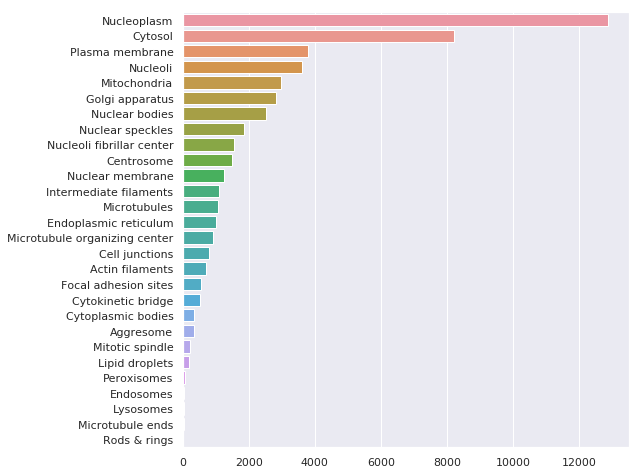

In [9]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False) #vertically
plt.figure(figsize=(8,8))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

How many targets for each image are the most common:
1)90 % of the images have 1 or 2 labels
2)Few have more than 2 labels

Text(0,0.5,'% of train data')

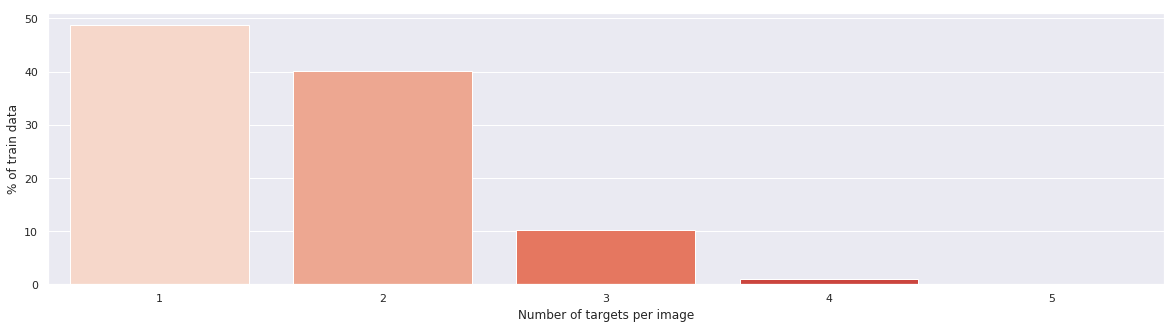

In [10]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1) #horizontally
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of train data")

Check for correlation between the protein classes
 - This will help us see that some proteins come together often

Takeaway:
1)Many targets have slight correlation
2)Endosomes and Lysosomes often occur together

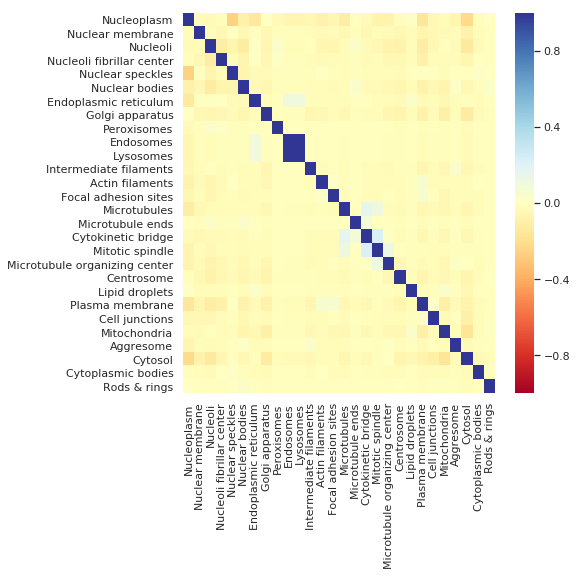

In [11]:
# For those with more than one class, we check the degree of correlation
plt.figure(figsize=(7,7))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

Further exploration of groups showing some degree of correlation

In [12]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

Text(0,0.5,'Counts in train data')

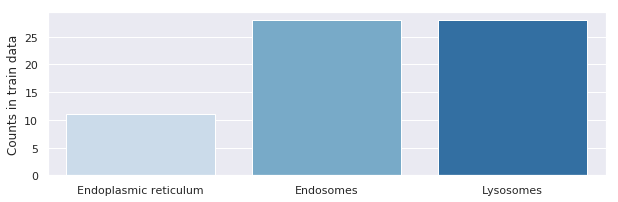

In [13]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")
plt.ylabel("Counts in train data")

Text(0,0.5,'Counts in train data')

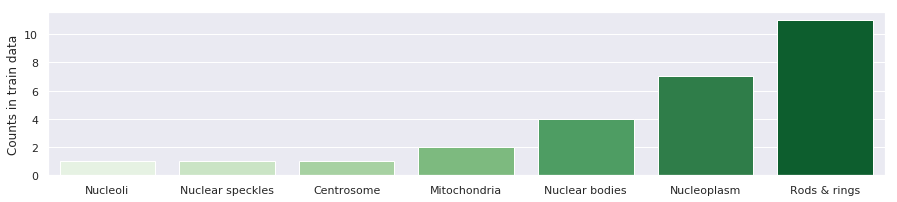

In [14]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")
plt.ylabel("Counts in train data")

Text(0,0.5,'Counts in train data')

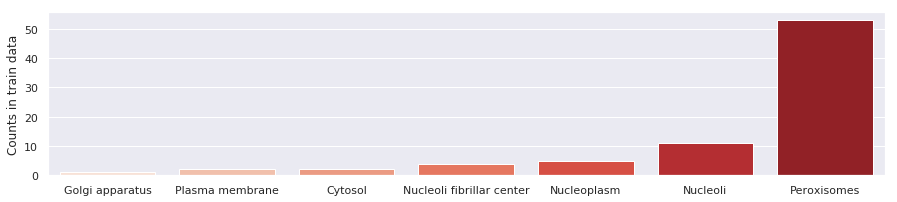

In [15]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")
plt.ylabel("Counts in train data")

Images in the train folder

In [16]:
from os import listdir

files = listdir("../input/train")
for n in range(10):
    print(files[n])

5e3a2e6a-bb9c-11e8-b2b9-ac1f6b6435d0_red.png
9891a4fa-bba4-11e8-b2b9-ac1f6b6435d0_red.png
315a9edc-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
437fa1ce-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
8a51782e-bb9b-11e8-b2b9-ac1f6b6435d0_green.png
0df0c3aa-bbca-11e8-b2bc-ac1f6b6435d0_blue.png
bf0b3946-bbba-11e8-b2ba-ac1f6b6435d0_red.png
641a0682-bbb7-11e8-b2ba-ac1f6b6435d0_green.png
05d32f36-bba3-11e8-b2b9-ac1f6b6435d0_red.png
168cbdc8-bb9f-11e8-b2b9-ac1f6b6435d0_red.png


Understanding the 4 color channels of the subcellular protein images (R,G,B,Y).
1. The green scale image is used to identify the protein whereas the others are used for reference.
2. Each color channel is represented by an image with the same base name but the color name appended to the base name.

In [17]:
train_path = "../input/train/"
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images

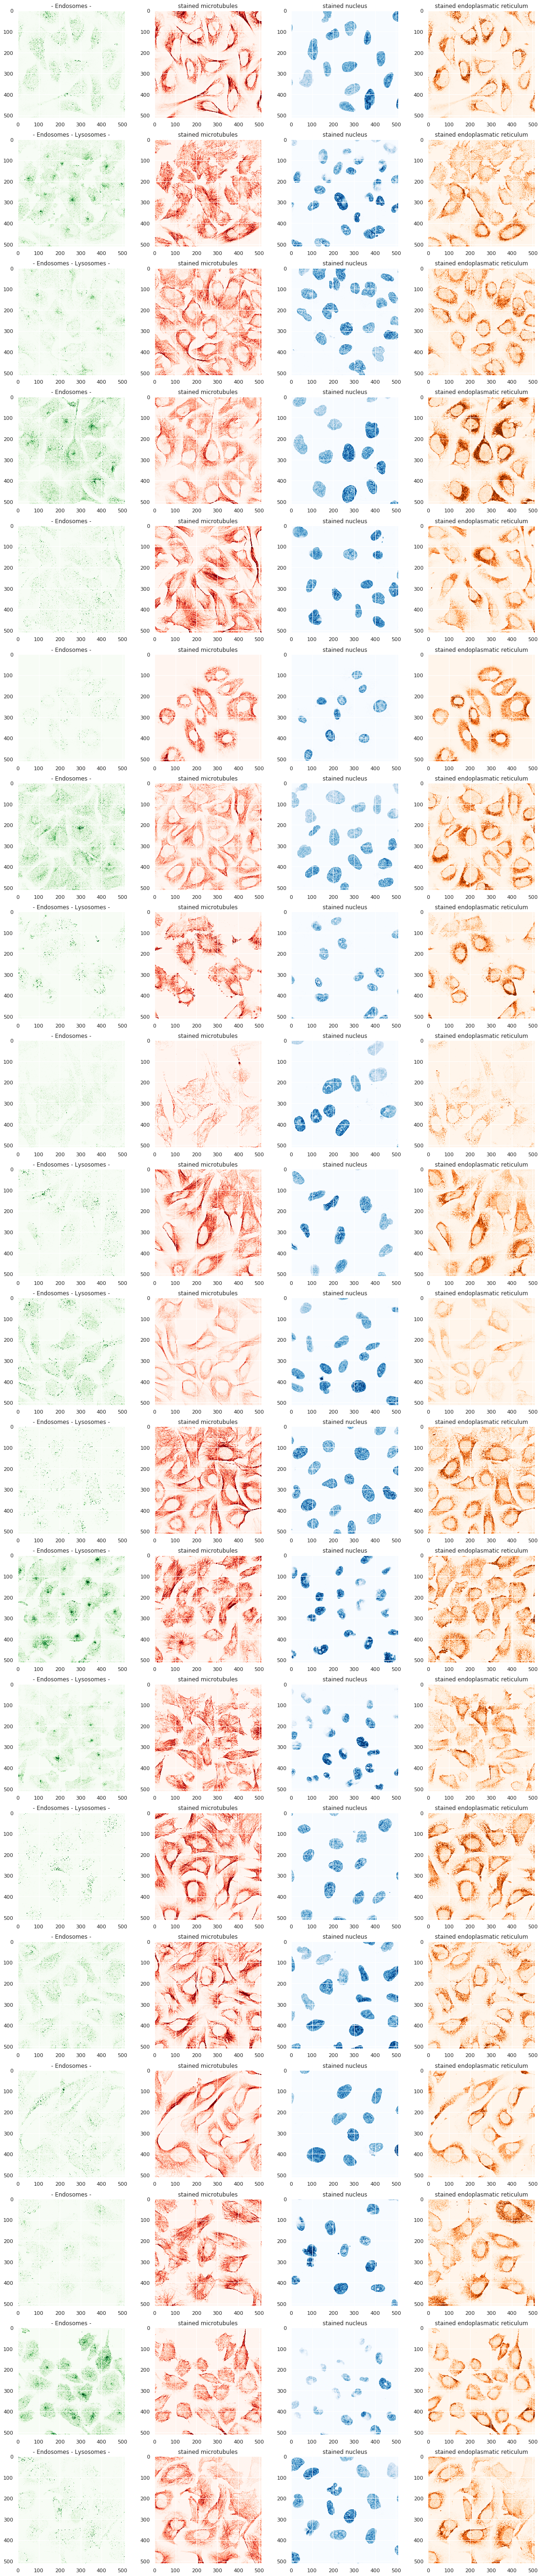

In [18]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 20
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

In [19]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

Processing the data to feed into the model

In [20]:
path_to_train = '/kaggle/input/train/'
data = pd.read_csv('/kaggle/input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

We've formed a numpy array of dictionaries, each dictionary holding two values:
1. Path of the image [Not including the colors, only the absolute path]
2. Classes of proteins in the image

In [21]:
train_dataset_info

array([{'path': '/kaggle/input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '/kaggle/input/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '/kaggle/input/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '/kaggle/input/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '/kaggle/input/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '/kaggle/input/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

Splitting the data into Train and Test Sets

In [22]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator
- It is a helper class that is used to generate batches of training input into our model

In [23]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28)) # Creating label tensors for each batch where all 28 values are originally zero
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1 # Change those values to one which are present in the image
            yield batch_images, batch_labels
            
    # We club the four color channels into one image and that to our set. This can be seen below where we visualise the first five images in our set
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1])) # resizing the image
        image = np.divide(image, 255) # Normalising the image
        return image  
                
    # Random augmentation based modification. This means each image appended to our set is rotated or flipped by some degree if augmentation is set to True which it is.
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [24]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 0.994997819907525


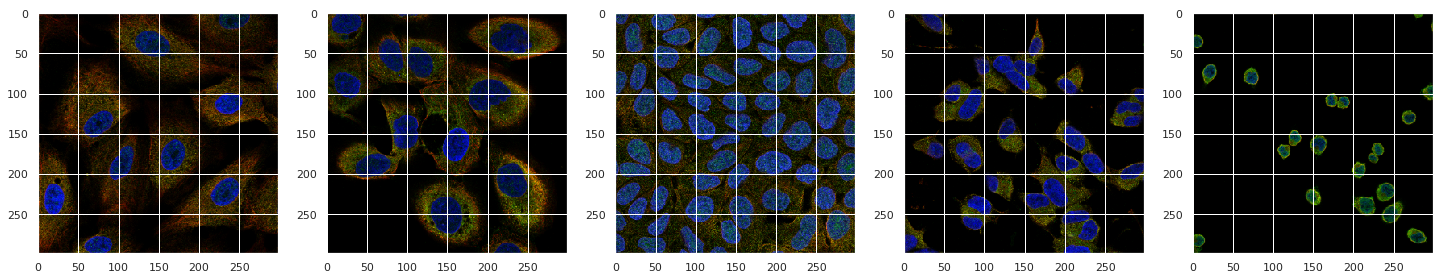

In [25]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model
 - Tools - Keras and Tensorflow

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [27]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [28]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [29]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

219062272/219055592 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (

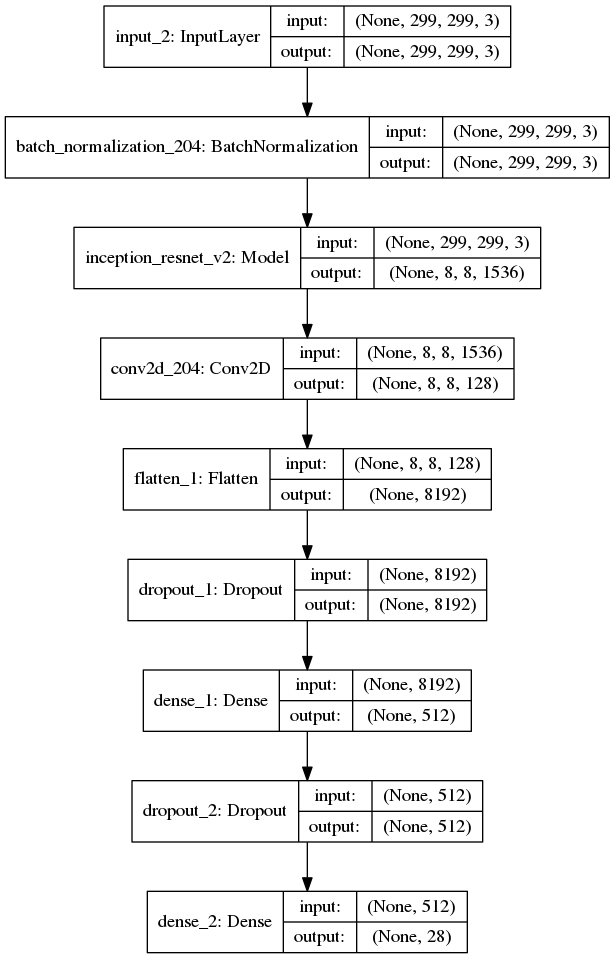

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image.open('model_plot.png')


### Train model

In [31]:

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpointer = ModelCheckpoint(
    '/kaggle/working/InceptionResNetV2.model',
    verbose=2, save_weights_only=True, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)


model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

# model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=100, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/100
100/100 [==============================] - 69s 689ms/step - loss: 0.2747 - acc: 0.9040 - f1: 0.0494 - val_loss: 0.2088 - val_acc: 0.9452 - val_f1: 0.0255

Epoch 00001: val_loss improved from inf to 0.20884, saving model to /kaggle/working/InceptionResNetV2.model
Epoch 2/100
100/100 [==============================] - 42s 422ms/step - loss: 0.2198 - acc: 0.9317 - f1: 0.0487 - val_loss: 0.2112 - val_acc: 0.9424 - val_f1: 0.0263

Epoch 00002: val_loss did not improve from 0.20884
Epoch 3/100
100/100 [==============================] - 44s 438ms/step - loss: 0.2068 - acc: 0.9345 - f1: 0.0469 - val_loss: 0.2113 - val_acc: 0.9395 - val_f1: 0.0278

Epoch 00003: val_loss did not improve from 0.20884
Epoch 4/100
100/100 [==============================] - 43s 433ms/step - loss: 0.2001 - acc: 0.9377 - f1: 0.0453 - val_loss: 0.2118 - val_acc: 0.9427 - val_f1: 0.0271

Epoch 00004: val_loss did not improve from 0.20884
Epoch 5/100
100/100 [==============================] - 44s 441ms/step -

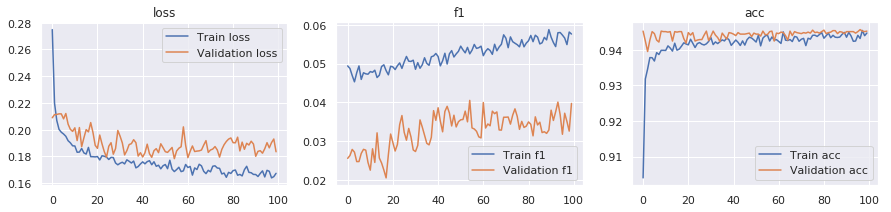

In [32]:
show_history(history)

Testing the model using Examples:

Example from Test and Train sets

For train:

0020af02-bbba-11e8-b2ba-ac1f6b6435d0

006f3dde-bbc9-11e8-b2bc-ac1f6b6435d0

0089bdfe-bbc8-11e8-b2bc-ac1f6b6435d0


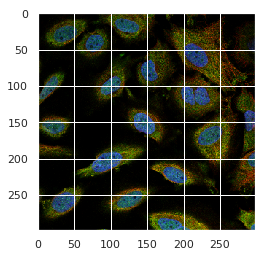

In [33]:
path = os.path.join('../input/train','0089bdfe-bbc8-11e8-b2bc-ac1f6b6435d0')
image = data_generator.load_image(path, INPUT_SHAPE)
plt.imshow(image)

Thresholds between 0.05 to 0.2 are working well at predicting the protein classes

In [34]:
def generate_classes(image,model):
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.05]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    return str_predict_label
result = generate_classes(image,model)
result_ = result.split(' ')

In [35]:
linter = []
for i in result_:
    linter.append(label_names[int(i)])
print(result)
print(linter)

0 1 2 3 4 5 7 18 19 22 23 25
['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center', 'Nuclear speckles', 'Nuclear bodies', 'Golgi apparatus', 'Microtubule organizing center', 'Centrosome', 'Cell junctions', 'Mitochondria', 'Cytosol']


Takeaway from printing predicted for every image in test and even train set:
* Majority of them had 0 and/or 25 which concludes that the amount of images containing Nucleoplasm and Cytosol where huge and highlights the imbalance in the dataset.
* Thresholds for the sigmoid functions worked well between 0.05 to 0.2.
 - In the case of 0.05 more classes were being predicted but it would contain most of the true predictions.
 - In the case of 1.0 some gave accurate results whereas some gave only 'Nucleoplasm' as class.
 - In the case of 2.0, most of them were predicting 'Nucleoplasm' and/or 'Cytosol', which also highlights the imbalance in the dataset. 
- Mean accuracy of the model on the classification task was around 94%
- Mean f1 score of the model varied around 0.03 - 0.05

In [36]:
model.save('Human Protein Atlas Model')

In [37]:
from IPython.display import FileLink
FileLink('Human Protein Atlas Model')

/kaggle/working/Human Protein Atlas Model

In [38]:
FileLink('InceptionResNetV2.model')

/kaggle/working/InceptionResNetV2.model